# Beginners' tutorial: Bayesian inference & optimisation with Pints

**Prerequisites** for running the code in this notebook are Python 3 with the modules below. All of the modules used, except Pints, are available from PyPI with the Python shell command `pip install <module name here>`.

In [2]:
import numpy as np
import math
import matplotlib.pyplot as plt
import scipy
from scipy import optimize, integrate
import pints

# Table of Contents
1. [**Bayesian probability revision**](#probability)
1. [**The model**](#model)
1. [**Bayesian optimisation**](#optimisation)
1. [**Bayesian sampling/MCMC**](#sampling)
1. [**Conclusion**](#conclusion)

# Bayesian probability revision <a class="anchor" id="probability"></a>

This notebook uses the following naming conventions:-  
**$y$:** Measured output from the system (or $y_{model}$, the model output)   
**$\theta$, theta:** Model parameters (in our example, $\theta=k$)  
**$k$:** Decay constant (the single parameter in our example model)  
**$\sigma$, sigma:** Variance of the measurement error  

We want to find $P(\theta|y)$ (the posterior probability), which is  the probability distribution on the left hand side of Bayes' rule (equation 1, below).
\begin{equation}
P(\theta|y) = \frac{P(y|\theta) P(\theta)}{P(y)}
\tag{1}
\end{equation}

For our example, a Gaussian probability distribution (i.e. normal distribution) is commonly used to compare to measured data, $P(y|\theta) = \frac{1}{\sqrt{2\pi\sigma^2}}e^{\frac{-(y-\theta)^2}{2\sigma^2}}$.  
This seems reasonable because random noise often behaves in a roughly Gaussian way. We decide on a uniform prior between 0 and 10, to show that before analysis we believe that $k$ could equally be any value between 0 and 10.  
Therefore we can calculate the numerator of Bayes' rule as follows.

\begin{equation}
\text{Numerator} = P(y|\theta) P(\theta) = \frac{1}{\sqrt{2\pi\sigma^2}}e^{\frac{-(y-\theta)^2}{2\sigma^2}} \cdot U(0,10)
\tag{2}
\end{equation}

In Bayes' rule, the denominator $P(y)$ does not vary with parameters. This means that, wherever we compare $P(\theta|y)$ between two sets of parameters, the denominator $P(y)$ cancels (assuming that both use the same $y$). Due to this, the denominator can safely be ignored when calculating relative posteriors.

Bayesian probability is a complex subject, so by necessity this can only be a brief review. Below are some resources to learn more:-
* *Bayesian Data Analysis, Third Edition*; Gelman et al.; 2014; CRC Press
* *A Student's Guide to Bayesian Statistics*; Lambert; 2018; SAGE Publishing
* [Bayesian Short Course](https://ben-lambert.com/bayesian-short-course/); Lambert, with [accompanying video lectures](https://www.youtube.com/playlist?list=PLwJRxp3blEvZ8AKMXOy0fc0cqT61GsKCG)

# The model <a class="anchor" id="model"></a>

PINTS, and Bayesian inference in general, can be applied to many real-life systems: anything for which you can propose a model and measure the input and output. For example, optimisation has been applied to fields as disparate as robotics control, ranking algorithms, and particle physics.  
For this example case we will use pharmacokinetics, which is the estimation of drug distribution in the body. The simplest model for this treats the entire body as one big sponge, and so is simple exponential decay.

For pharmacokinetics, the system of interest is the distribution of a drug in the body. The input is some dose, and the system's output is concentration of the drug, measured in a particular compartment at several points in time.  
In this example we use exponential decay, which only has one parameter in the model, labelled $k$ here. The output, $y$, is defined by the ODE:- 
\begin{equation}
\frac{d y}{d t} = -k \cdot y
\tag{3}
\end{equation}

Because this model treats the entire body as one large compartment, it is sometimes called a "one compartment model". We define this model in Python below.

In [3]:
# Defining variables for use later
k = 1.5 # from equation 3
y0 = 1
times = np.linspace(0,10,50)

# A one-compartment PK model is basically an ODE for an exponential decay curve
def onecomp(y, t, k):
    """A one-compartment PK model, aka simple exponential decay
    
    Parameters
    ----------
    y: float
        y at time t
    t: float
        time
    k: float
        model parameter
    """
    dydt = -k * y
    return dydt

Now that we have a model and an initial value $y0$, we want to estimate, for any given parameter $k$, $y$ for all values of $t$.  
Ordinary Differential Equations can be solved with numerical methods such as [Runge-Kutta](https://en.wikipedia.org/wiki/Runge%E2%80%93Kutta_methods). The simplest of these is known as Forward Euler.

The popular Python package scipy also has a built-in method, odeint, that integrates ODEs.

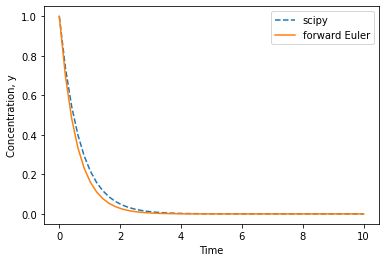

In [4]:
# You can solve ODEs with the Forward Euler method
def ForwardEuler(func, k, y0, times):
    """Numerically calculate an ODE (forward Euler technique)

    Parameters
    ----------
    func: function
        function giving the derivative
    k: float
        parameter the function requires as input
    y0: float
        y at t=0
    times: list
        array of times at which to calculate y
    """
    y = y0
    y_solution = [y0]
    h = times[2] - times[1]
    
    for n in times[:-1]:
        dy = func(y, n, k)
        y = y + h*dy
        y_solution.append(y)

    return y_solution

# You can also solve ODEs with scipy.integrate.odeint
def simulate(func, parameters, y0, times):
    """Numerically calculate an ODE
    
    Parameters
    ----------
    func: function
        function giving the derivative
    parameters: list
        parameters the function requires as input
    y0: float
        y at t=0
    times: list
        array of times at which to calculate y
    """
    l = scipy.integrate.odeint(func, y0, times, (parameters,)) # returns a list of lists
    flatlist = [item for sublist in l for item in sublist] # to single list of 'y's
    return flatlist

# This is what the system output looks like. We don't actually know these values
actual_values_euler = ForwardEuler(onecomp, k, y0, times)
actual_values = simulate(onecomp, k, y0, times)

# Plot the model results
plt.figure()
plt.xlabel('Time')
plt.ylabel('Concentration, y')
plt.plot(times, actual_values, '--', label='scipy')
plt.plot(times, actual_values_euler, label='forward Euler')
plt.legend()
plt.show()

# Bayesian optimisation <a class="anchor" id="optimisation"></a>

In optimisation, you measure the output of a system with a known input, compare it to the measured output of the 'real' system, and so estimate the parameters most likely to give that output.  
We will use the example model shown above: so the problem becomes this:-  
**Problem to solve: which value of _k_ gives the model output that best matches the measured data?**

In this case, we first require measurements from the real-life system to compare our estimates to. Any measurements will have some measurement error, which we're modelling as gaussian noise below.

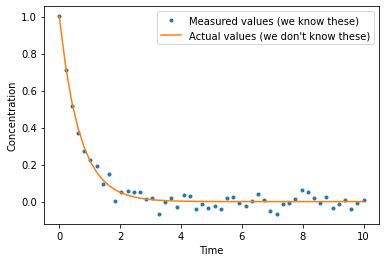

In [5]:
# Make noisy data that we're inferring from. noisy_data is known to us.
noise = np.random.normal(0, 0.03, len(actual_values))
noisy_data = actual_values + noise
plt.figure()
plt.plot(times, noisy_data, '.', label='Measured values (we know these)')
plt.plot(times, actual_values, label='Actual values (we don\'t know these)')
plt.xlabel('Time')
plt.ylabel('Concentration')
plt.legend()
plt.show()

We're trying to find which value of $k$ makes our model output the closest to the real system output, assuming that the input dose for each is the same. To do this we define a function, `scalar_to_minimise`, whose output reduces in size, the closer model output is to measured system output.

In [6]:
# So what do we want to minimise?
def sumofsquares(y_model, y_data):
    """Gives the sum of the square of all errors between model and experimental data.
    In
    y_model: list of output values from model
    y_data: list of experimental (i.e. noisy) values
    
    Out: the sum of square error
    """
    sq_error = []
    for t in range(len(y_model)):
        sq_error.append((y_data[t] - y_model[t])**2)
    
    return sum(sq_error)

By modelling many values of $k$ and finding the one that gives the lowest value from `scalar_to_minimise`, we can make a good estimate of $k$ in the real-life system. As you can see, this is inherently imperfect, but can be quite accurate.

In [7]:
# Optimise it with scipy
def scalar_to_minimise(parameters):
    """For a one compartment model & sum of squares this is what's minimised"""
    y_model = simulate(onecomp, parameters, 1, times)
    y_data = noisy_data
    return sumofsquares(y_model, y_data) / len(y_model)

start_params = 11
result = scipy.optimize.minimize_scalar(scalar_to_minimise)
print('Calculated k: \t'+str(result.x))
print('Real k: \t'+str(k))

Calculated k: 	1.5329976105752299
Real k: 	1.5


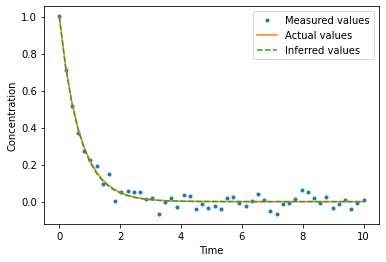

In [8]:
# What does that look like?
recon_model = simulate(onecomp, result.x, 1, times)
plt.figure()
plt.plot(times, noisy_data, '.', label='Measured values')
plt.plot(times, actual_values, label='Actual values')
plt.plot(times, recon_model, '--', label='Inferred values')
plt.xlabel('Time')
plt.ylabel('Concentration')
plt.legend()
plt.show()

## Using PINTS
The work above estimates $k$ pretty well simply based on minimising the output of `scalar_to_minimise`. So how, and more importantly why, do we use PINTS?

PINTS formalises the process of creating an optimiser, making it more re-usable in different settings. Rather than rewriting code every time new measures are needed, PINTS allows us to change to different error measures, optimisation methods, and more, relatively simply. Not only that, but PINTS is both faster to write and faster to run than the section above!

Custom calculation result: 	1.5329976105752299
Pints calculation result: 	1.5329975909539884


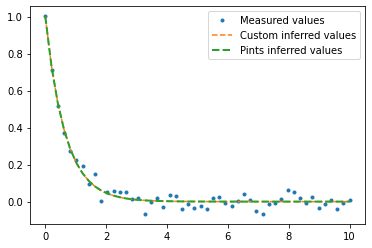

In [9]:
# Need to make the model into a Pints one
class PintsOneComp(pints.ForwardModel):
    def n_parameters(self):
        return 1
    def simulate(self, parameter, times):
        return simulate(onecomp, parameter, 1, times)
    
problem = pints.SingleOutputProblem(PintsOneComp(), times, noisy_data) # Create a model instance with measured data
error_measure = pints.SumOfSquaresError(problem) # Define the error measure to be used (as sumofsquares function)
optimisation = pints.OptimisationController(error_measure, [1], method=pints.XNES) # Define a statistical problem
optimisation.set_log_to_screen(False) # Suppress log output
parameters, error = optimisation.run() # Run the statistical model

# How does it look?
print('Custom calculation result: \t'+str(result.x))
print('Pints calculation result: \t'+str(parameters[0]))
plt.figure()
plt.plot(times, noisy_data, '.', label='Measured values')
plt.plot(times, recon_model, '--', label='Custom inferred values')
plt.plot(times, PintsOneComp().simulate(parameters, times), '--', lw=2, label='Pints inferred values')
plt.legend()
plt.show()

There is an important conceptual change in the code above. Previously, we have dealt with a _physical_ model of the real-life system of interest (the function `onecomp`). In the example described, the physical model takes $y(t_n, param)$ as input and gives $\frac{d}{dt}y(t_n, param)$ as output. With PINTS, the physical model is provided by the user as a `simulate` function.

PINTS provides a _statistical_ model, which takes measured data $y_{noisy}(t)$ and provides parameter(s) as output. In the example described, the statistical model is a `pints.SingleOutputProblem` instance, `problem`, taking measured data, a time array, and the user-defined class `PintsOneComp` as input.

In order to allow PINTS to use the physical model, the user needs to provide a class inheriting from `pints.ForwardModel`. 

# Bayesian sampling <a class="anchor" id="sampling"></a>

Optimisation gives us the most likely parameters, but sampling can give a probability distribution of different parameter values. The method we'll use here is [Metropolis Hastings](https://en.wikipedia.org/wiki/Metropolis%E2%80%93Hastings_algorithm). In our example model, our only model parameter ($\theta$) is $k$ (the decay constant in equation 3 at the start of this tutorial).  
Therefore our problem is this:-  
**Problem to solve: what is the _distribution_ of likely _k_ values, given our data and assumptions?**

The Metropolis-Hastings algorithm creates a series of potential values of $\theta$ by making random proposals for new $\theta$s and calculating the numerator of Bayes' rule (equation 2) for each one.

**Steps for Metropolis Hastings**
1. Start with an arbitrary $\theta$ (a $k$ and a $\sigma$). Calculate $(\text{prior} \cdot \text{likelihood})$.
2. Move to a different $\theta$ (selected from a normal distribution about the existing value). Calculate $(\text{prior} \cdot \text{likelihood})$.
3. If new $(\text{prior} \cdot \text{likelihood})$ is higher than old, keep it and add the new $\theta$ to a list. If not, keep it if rand(0->1) > (old/new). If neither of these work, move back to the old one and add that instead.
4. Repeat steps 2-3 for N steps. 
5. Count your list of $\theta$s into bins and draw a histogram. 

The distribution of your histogram should approximate the posterior probability distribution. This may not be apparent at first glance; for more information please see the [resources above](#probability).

In [10]:
# This model stores all the model-related variables, for simplicity.

class OdeModel():
    
    def __init__(self, thetas, covariates, prior, likelihood, modeltype):
        self.thetas = thetas
        self.covariates = covariates
        self.modeltype = modeltype
        self.prior = prior
        self.likelihood = likelihood

The functions below provide the prior and likelihood for the numerator of Bayes' rule.  
In this case, we use a uniform prior $P(\theta) ~ U(0,10)$, i.e. for any input between 0 & 10, it outputs 0.1, else 0.  
The likelihood $P(y|\theta)$ (probability that theta could give the output `y_data`) in this case gives $\frac{1}{\sqrt{2\pi\sigma^2}}e^{\frac{-(y_{data}-y_{\theta})^2}{2\sigma^2}}$.

In [11]:
def uniform_prior(theta):
    """Returns 0.1 if entire input list is between 0 & 10, else 0"""
    
    prior = []
    for key, param in theta.items():
        if param > 0 and param < 10:
            prior.append(0.1)
        else:
            prior.append(0)
            
    return min(prior)

In [12]:
def likelihood_k(theta, y_data):
    """Returns the likelihood, P(theta|y)"""
    k = theta['k']
    sigma = 0.03
    pdf = []
    y_model = simulate(onecomp, k, 1, times)
    other_bit = 1/(2*math.pi*sigma**2)
    for t in range(len(y_data)): # this loop gives a normally distributed pdf
        square_error = (y_data[t] - y_model[t])**2
        exponential = math.exp(-square_error/(2*sigma**2))
        pdf.append(exponential*other_bit)
    
    return np.prod(pdf)

The function `propose_new_theta` does steps 2 & 3 in the instructions above. It takes the model, the current $\theta$ value, and measured data.  
It returns an accepted value of $\theta$.  
This is `proposed_theta` if accepted, else it is `theta`.

In [13]:
def propose_new_theta(model, y_data, theta):
    """Randomly proposes a new theta and decides whether to accept or not
    In
    model: instance of OdeModel class
    y_data: list with experimental data
    theta: parameters, in a list
    
    Out: new parameters, either the same (if proposed not accepted) or different
    """

    numerator = model.prior(theta) * model.likelihood(theta, y_data)
    
    # randomly get a proposed theta & calculate its numerator
    proposed_theta = {}
    for key, value in theta.items():
        proposed_k = np.random.normal(value, model.covariates[key])
        proposed_theta[key] = proposed_k
    proposed_numerator = model.prior(proposed_theta) * model.likelihood(proposed_theta, y_data)
    
    # if the new numerator should be accepted (metropolis hastings criteria), replace theta
    if proposed_numerator == 0:
        pass
    elif proposed_numerator > numerator:
        theta = proposed_theta
        numerator = proposed_numerator
    elif np.random.rand() < proposed_numerator/numerator:
        theta = proposed_theta
        numerator = proposed_numerator

    return theta

In [14]:
# This just runs propose_new_theta repeatedly

def metropolis_singlethread(model, y_data, threadnum, max_iters):
    iters = 0
    
    while iters < max_iters:
        theta = propose_new_theta(model, y_data, model.thetas[threadnum][-1])
        model.thetas[threadnum].append(theta)
        iters = iters + 1

In [15]:
def metropolishastings(model, y_data, blocksize, number_of_blocks):
    n = 0
    while n < number_of_blocks:
        for threadnum, thetas_onelot in enumerate(model.thetas):
            metropolis_singlethread(model, y_data, threadnum, blocksize)
        n = n+1

Let's see this work. First, let's see what the likelihood is when we fix the measured data and take a variety of different proposed $k$ parameters.

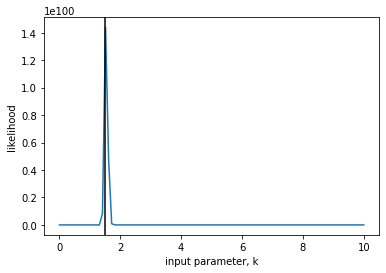

In [16]:
ks = np.linspace(0,10,100)
likelihoods = []
for n in ks:
    likelihoods.append(likelihood_k({'k':n}, noisy_data))

plt.figure()
plt.plot(ks, likelihoods)
plt.xlabel('input parameter, k')
plt.ylabel('likelihood')
plt.axvline(1.5, color='k', label='True value of k')
plt.show()

In [17]:
# Run the metropolis hastings algorithm

thetas_k = [[{'k':5}], [{'k':3}], [{'k':1}]] # Three initial guesses for k
covariates_k = {'k':0.05} # Step size (SD of normal distribution for choosing next proposed theta)
model = OdeModel(thetas_k, covariates_k, uniform_prior, likelihood_k, onecomp)
metropolishastings(model, noisy_data, 10, 100)

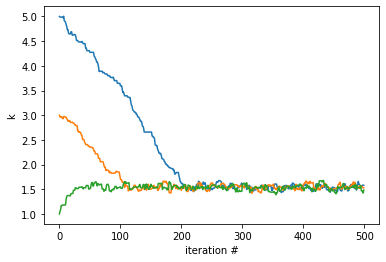

In [18]:
# This is how k looks (from all start-points) as the algorithm progresses

plt.figure()
for n in range(len(model.thetas)):
    ks_list= [theta['k'] for theta in model.thetas[n]]
    plt.plot(ks_list[:500]) # only first 500
plt.xlabel('iteration #')
plt.ylabel('k')
plt.show()

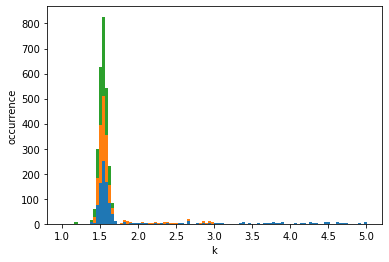

In [19]:
# Here are the occurrences of all k estimates throughout the algorithm

all_ks = []
for n in range(len(model.thetas)):
    ks_list = [theta['k'] for theta in model.thetas[n]]
    all_ks.append(ks_list)

plt.figure()
plt.hist(all_ks, bins=100, stacked=True)
plt.xlabel('k')
plt.ylabel('occurrence')
plt.show()

## Using PINTS
Now let's try the same thing as we have just done above, but using PINTS!  
Once again, it's much easier to type and quicker to run than our manual method above.

In [20]:
import pints

In [21]:
log_likelihood = pints.GaussianKnownSigmaLogLikelihood(problem, sigma=0.05) # Define & wrap a physical model
startpoints = [[1],[3],[5]] # Start 3 Markov chains from arbitrary points
mcmc = pints.MCMCController(log_likelihood, 3, startpoints, method=pints.HaarioBardenetACMC) # Define a statistical problem
mcmc.set_max_iterations(2000) # Set number of iterations to attempt
mcmc.set_log_to_screen(False) # Suppress log output
samples = mcmc.run() # Run the statistical model

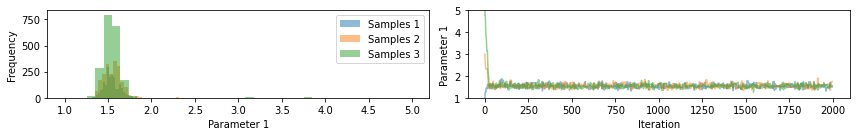

In [22]:
# Use a diagnostic plot to check if the chains have converged
import pints.plot
pints.plot.trace(samples)
plt.show()

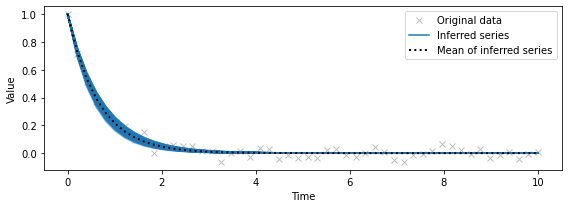

In [23]:
# Plot several predictions that are all likely sources of the experimental data
pints.plot.series(np.vstack(samples[:,1000:]), problem)
plt.show()

# Conclusion <a class="anchor" id="conclusion"></a>

Bayesian inference is a powerful tool for estimation of parameters in ODE models of time series. If the user can define the ODE model, and a method to solve it, PINTS can be used for quick and simple access to error measures and optimisation and sampling methods in order to probabilistically infer system parameters.